In [ ]:
import requests
import json
import pandas as pd
import numpy as np
from urllib.parse import urljoin
from tqdm import tqdm
from time import sleep
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
def get_data_and_next_page(response_text:str):
    start_idx = response_text.find('const data =') + len('const data =')
    end_idx = response_text.rfind(';', start_idx, response_text.find('const next ='))
    data_json = response_text[start_idx:end_idx].strip()
    data = json.loads(data_json)

    start_idx = response_text.find('const next =') + len('const next =')
    end_idx = response_text.find(';', start_idx)
    next_page = response_text[start_idx:end_idx].strip().strip('"')

    return data, next_page

def navigate_next(base_url, next_page):
    if next_page != "null":
        return urljoin(base_url, next_page)
    else:
        return None

def scrape_data(base_url, state_data):
    election_data = {"ID": [], "ST_NAME": [], "YEAR": [], "AC": [],
                 "CANDIDATE": [], "SEX": [], "AGE": [], "CATEGORY": [],
                 "PARTY": [], "VOTES": []}
    for entry in state_data:
        next = entry['link']
        url = urljoin(base_url, next)
        while True:
            response = requests.get(url)
            data, next_page = get_data_and_next_page(response.text)
            for row in tqdm(data, desc=f"Scraping data for year {entry['YEAR']}"):
                for key in election_data.keys():
                    election_data[key].append(str(row.get(key, list(row.values())[0])).strip())
            url = navigate_next(base_url, next_page)
            if not url:
                break
    return election_data

def save(ST_NAME, AC_NAME, election_data):
    df = pd.DataFrame(election_data)
    df.replace('', np.nan, inplace=True)
    df = df.loc[df['VOTES'] != "None"]
    df['AC'] = df['AC'].str.replace(r'^\d+\s+', '', regex=True)
    df['AC'] = df['AC'].str.replace(r'[^a-zA-Z\s\.]', '', regex=True)
    df['CANDIDATE'] = df['CANDIDATE'].str.replace(r'^\d+\s+', '', regex=True)
    df['CANDIDATE'] = df['CANDIDATE'].str.replace(r'[^a-zA-Z\s\.]', '', regex=True)
    df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
    df = df.drop_duplicates()
    df = df.drop_duplicates(subset=['ST_NAME', 'YEAR', 'AC', 'CANDIDATE', 'SEX', 'AGE', 'CATEGORY', 'PARTY', 'VOTES'])
    df.to_csv(f"{ST_NAME}.csv", index=False)
    condition = (df["AC"] == AC_NAME)
    df = df[condition]
    df.to_csv(f"{ST_NAME}_{AC_NAME}.csv", index=False)

def find_state_data(start_url, ST_NAME):
    url = start_url
    state_data = []
    n_pages = 10
    for i in tqdm(range(n_pages), desc="Crawling all pages"):
        if url:
            response = requests.get(url)
            data, next_page = get_data_and_next_page(response.text)
            state_data.extend([entry for entry in data if entry['ST_NAME'] == ST_NAME])
            url = navigate_next(start_url, next_page)
    return state_data

def main_scraper(ST_NAME, AC_NAME):
    start_url = "https://22f3001919.github.io/tds_project_1/"
    state_data = find_state_data(start_url, ST_NAME)

    if not state_data:
        print(f"No data found for state: {ST_NAME}")
        return

    election_data = scrape_data(start_url, state_data)
    save(ST_NAME, AC_NAME, election_data)
    return election_data


In [ ]:
ST_NAME = "ASSAM"
AC_NAME = "TINSUKIA"
# saves full state csv and also constituency csv
# scraped data undergoes priliminary cleaning as well
data = main_scraper(ST_NAME, AC_NAME)

Scraping data for year 2021: 100%|██████████| 384/384 [00:00<00:00, 68956.32it/s]
<ipython-input-2-13975e1e27af>:45: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)


In [ ]:
import pandas as pd

# Load the full state CSV file
state_csv_path = "ASSAM.csv"
state_df = pd.read_csv(state_csv_path)
print(f"Shape of full state CSV (ASSAM.csv): {state_df.shape}")
print(f"Size of full state CSV (ASSAM.csv): {state_df.size}")

# Load the constituency CSV file
constituency_csv_path = "ASSAM_TINSUKIA.csv"
constituency_df = pd.read_csv(constituency_csv_path)
print(f"Shape of constituency CSV (ASSAM_TINSUKIA.csv): {constituency_df.shape}")
print(f"Size of constituency CSV (ASSAM_TINSUKIA.csv): {constituency_df.size}")


Shape of full state CSV (ASSAM.csv): (12709, 10)
Size of full state CSV (ASSAM.csv): 127090
Shape of constituency CSV (ASSAM_TINSUKIA.csv): (121, 10)
Size of constituency CSV (ASSAM_TINSUKIA.csv): 1210


In [ ]:


# Question 7: Calculate the year with the biggest difference in votes for constituencies containing 'TINSUKIA'
file_path = 'ASSAM.csv'
data = pd.read_csv(file_path)
filtered_data = data[data['AC'].str.contains('TINSUKIA', case=False, na=False)]

if filtered_data.empty:
    raise ValueError("No records found for constituencies containing 'TINSUKIA'.")

vote_diff = filtered_data.groupby('YEAR')['VOTES'].agg(['max', 'min'])
vote_diff['diff'] = vote_diff['max'] - vote_diff['min']
max_diff_year = vote_diff['diff'].idxmax()

# Print the result
print(f"Year with the biggest difference in votes for constituencies containing 'TINSUKIA': {max_diff_year}")


Year with the biggest difference in votes for constituencies containing 'TINSUKIA': 2021


In [ ]:
import pandas as pd

# Load the cleaned dataset
file_path = 'ASSAM.csv'
cleaned_data = pd.read_csv(file_path)

# Filter the data for the constituency "Tinsukia"
tinsukia_data = cleaned_data[cleaned_data['AC'].str.upper() == 'TINSUKIA']

# Filter for female candidates
female_candidates_tinsukia = tinsukia_data[tinsukia_data['SEX'] == 'F']

# Count the number of female candidates per election year and collect their names
female_candidates_per_year = female_candidates_tinsukia.groupby('YEAR').agg({
    'CANDIDATE': 'size',
    'CANDIDATE': lambda x: list(x)
})

# Find the maximum number of female candidates in a single election
max_female_candidates_tinsukia = female_candidates_per_year['CANDIDATE'].apply(len).max()

# Find the year(s) with the maximum number of female candidates
years_with_max_female_candidates = female_candidates_per_year[
    female_candidates_per_year['CANDIDATE'].apply(len) == max_female_candidates_tinsukia
]

# Print the result
print("The highest number of female candidates that contested a single election in Tinsukia:", max_female_candidates_tinsukia)
for year, row in years_with_max_female_candidates.iterrows():
    print(f"Year: {year}, Female Candidates: {', '.join(row['CANDIDATE'])}")


The highest number of female candidates that contested a single election in Tinsukia: 1
Year: 1985, Female Candidates: LABANYA GOGOI
Year: 1996, Female Candidates: NIRMALA SINGH
Year: 2021, Female Candidates: HIRA DEVI


In [ ]:
ac_df = pd.read_csv(f"{ST_NAME}_{AC_NAME}.csv")
ac_df['DEPOSIT_THRESHOLD'] = 1/6 * ac_df.groupby('YEAR')['VOTES'].transform('sum')
ac_df = ac_df[ac_df['CANDIDATE'] != "NOTA"]
ac_df[ac_df['VOTES'] < ac_df['DEPOSIT_THRESHOLD']].shape[0]

88

In [ ]:
import pandas as pd

# Load the dataset for the given AC_NAME
file_path = 'ASSAM_TINSUKIA.csv'  # Adjust the file path if needed
ac_df = pd.read_csv(file_path)

# Filter the data for the constituency "Tinsukia"
tinsukia_data = ac_df[ac_df['AC'].str.upper() == 'TINSUKIA']

# Calculate the margin percentage for each year
margin_percentages = []

for year, group in tinsukia_data.groupby('YEAR'):
    if len(group) > 1:  # Ensure there are at least two candidates
        sorted_group = group.sort_values(by='VOTES', ascending=False)
        winner_votes = sorted_group.iloc[0]['VOTES']
        runner_up_votes = sorted_group.iloc[1]['VOTES']
        margin_percentage = ((winner_votes - runner_up_votes) / winner_votes) * 100
        margin_percentages.append(margin_percentage)

# Find the highest margin percentage
highest_margin_percentage = max(margin_percentages) if margin_percentages else 0

# Print the result to 2 decimal places
highest_margin_percentage = round(highest_margin_percentage, 2)
print(f"The highest margin percentage by which the winning candidate has defeated the runner-up in Tinsukia is: {highest_margin_percentage}%")


The highest margin percentage by which the winning candidate has defeated the runner-up in Tinsukia is: 82.46%


In [ ]:
ac_df = pd.read_csv(f"{ST_NAME}_{AC_NAME}.csv")
winners = ac_df.loc[ac_df.groupby('YEAR')['VOTES'].idxmax()].copy()
total_votes =  ac_df.groupby('YEAR')['VOTES'].sum().values
winners["VOTE_SHARE"] = 100 * ac_df.loc[ac_df.groupby('YEAR')['VOTES'].idxmax()]["VOTES"].values / total_votes
winners_above_50 = winners[winners["VOTE_SHARE"] > 50]
winners_above_50["YEAR"].max()

2021

In [ ]:
ac_df = pd.read_csv(f"{ST_NAME}_{AC_NAME}.csv")
df_sorted = ac_df.sort_values(by=['YEAR', 'VOTES'], ascending=[True, False])
grouped = df_sorted.groupby('YEAR')
def vote_difference(group):
    return group.iloc[0]['VOTES'] - group.iloc[-1]['VOTES']

differences = grouped.apply(vote_difference)
differences.max()

85089.0

In [ ]:
import pandas as pd

# Load the dataset for the given AC_NAME
file_path = 'ASSAM_TINSUKIA.csv'  # Adjust the file path if needed
ac_df = pd.read_csv(file_path)

# Filter the data for the constituency "Tinsukia"
tinsukia_data = ac_df[ac_df['AC'].str.upper() == 'TINSUKIA']

# Calculate the margin percentage for each year
tinsukia_data['Margin Percentage'] = 0.0

for year, group in tinsukia_data.groupby('YEAR'):
    if len(group) > 1:  # Ensure there are at least two candidates
        sorted_group = group.sort_values(by='VOTES', ascending=False)
        winner_votes = sorted_group.iloc[0]['VOTES']
        runner_up_votes = sorted_group.iloc[1]['VOTES']
        margin_percentage = ((winner_votes - runner_up_votes) / winner_votes) * 100
        tinsukia_data.loc[tinsukia_data['YEAR'] == year, 'Margin Percentage'] = margin_percentage

# Extract the year with the biggest margin percentage win for Tinsukia constituencies
max_margin_year_row = tinsukia_data.loc[tinsukia_data['Margin Percentage'].idxmax()]

# Check for years with the same margin percentage
max_margin = tinsukia_data['Margin Percentage'].max()
years_with_max_margin = tinsukia_data[tinsukia_data['Margin Percentage'] == max_margin]['YEAR']

# If there are multiple years with the same margin, choose the latest one
latest_max_margin_year = years_with_max_margin.max()

# Print the result
print(f"The year with the biggest margin percentage win for Tinsukia constituencies is: {latest_max_margin_year}")



The year with the biggest margin percentage win for Tinsukia constituencies is: 2021


In [ ]:
state_df = pd.read_csv(f"{ST_NAME}.csv")
df_filtered = state_df.groupby(['YEAR', 'AC']).filter(lambda x: (x['SEX'] == 'F').any())
df_female = df_filtered[df_filtered['SEX'] == 'F'][['YEAR', 'VOTES']].rename(columns={'VOTES': 'FEMALE_VOTES'})
female_votes_by_year = df_female.groupby('YEAR')['FEMALE_VOTES'].sum()
df_male = df_filtered[df_filtered['SEX'] == 'M'][['YEAR', 'VOTES']].rename(columns={'VOTES': 'MALE_VOTES'})
male_votes_by_year = df_male.groupby('YEAR')["MALE_VOTES"].sum()
male_votes_by_year.corr(female_votes_by_year)

0.9666451369802544

In [ ]:
import pandas as pd

# Load the dataset
state_df = pd.read_csv(f"{ST_NAME}.csv")

# Filter the data to include only constituencies and election years with at least one female candidate
df_filtered = state_df.groupby(['YEAR', 'AC']).filter(lambda x: (x['SEX'] == 'F').any())

# Aggregate votes for female candidates
df_female = df_filtered[df_filtered['SEX'] == 'F'][['YEAR', 'VOTES']].rename(columns={'VOTES': 'FEMALE_VOTES'})
female_votes_by_year = df_female.groupby('YEAR')['FEMALE_VOTES'].sum()

# Aggregate votes for male candidates
df_male = df_filtered[df_filtered['SEX'] == 'M'][['YEAR', 'VOTES']].rename(columns={'VOTES': 'MALE_VOTES'})
male_votes_by_year = df_male.groupby('YEAR')['MALE_VOTES'].sum()

# Merge the female and male votes data by year
votes_by_year = pd.DataFrame({
    'FEMALE_VOTES': female_votes_by_year,
    'MALE_VOTES': male_votes_by_year
}).dropna()  # Drop rows where either FEMALE_VOTES or MALE_VOTES is NaN

# Calculate the Pearson correlation coefficient
correlation_coefficient = votes_by_year.corr().loc['FEMALE_VOTES', 'MALE_VOTES']

# Round off the result to 4 decimal points
correlation_coefficient_rounded = round(correlation_coefficient, 4)

print(correlation_coefficient_rounded)


0.9666


In [ ]:
state_df = pd.read_csv(f"{ST_NAME}.csv")
grouped = state_df.groupby('YEAR')
Q1 = grouped['VOTES'].transform(lambda x: x.quantile(0.25))
Q3 = grouped['VOTES'].transform(lambda x: x.quantile(0.75))
IQR = Q3 - Q1
lb = Q1 - 1.5 * IQR
ub = Q3 + 1.5 * IQR
condition = (state_df['VOTES'] < lb) | (state_df['VOTES'] > ub)
print("List of years sorted in descending order of number of outliers:")
state_df[condition]["YEAR"].value_counts()

List of years sorted in descending order of number of outliers:


YEAR
1991    251
2021    174
1996    134
1985    125
2016    117
2011     38
1983     34
1978     25
1951     24
2006     19
2001     15
1957      5
1962      4
1967      4
1972      3
Name: count, dtype: int64

In [ ]:
pip install altair vega_datasets


In [ ]:
import pandas as pd
import altair as alt

# Load the data
ST_NAME = 'ASSAM'
state_df = pd.read_csv("ASSAM.csv")

# Drop rows where 'VOTES' is NaN or blank
state_df = state_df.dropna(subset=['VOTES'])

# Convert the 'YEAR' column to a string for better axis formatting
state_df['YEAR'] = state_df['YEAR'].astype(str)

# Calculate IQR and outlier bounds
Q1 = state_df['VOTES'].quantile(0.25)
Q3 = state_df['VOTES'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter outliers
outliers_df = state_df[(state_df['VOTES'] < lower_bound) | (state_df['VOTES'] > upper_bound)]

# Configure Altair to allow larger datasets
alt.data_transformers.disable_max_rows()

# Create a box plot with IQR and whiskers
box_plot = alt.Chart(state_df).mark_boxplot(extent='min-max').encode(
    x=alt.X('YEAR:O', title='Election Year', axis=alt.Axis(labelAngle=45)),
    y=alt.Y('VOTES:Q', title='Number of Votes'),
    tooltip=['CANDIDATE', 'VOTES']
).properties(
    title='Distribution of Candidate Votes by Election Year in Assam',
    width=600,
    height=400
)

# Create a chart for outliers
outliers = alt.Chart(outliers_df).mark_point(
    color='red', size=30
).encode(
    x='YEAR:O',
    y='VOTES:Q'
)

# Combine the box plot and outliers
final_plot = box_plot + outliers

# Apply configuration settings to the final plot
final_plot = final_plot.configure_axis(
    grid=True,
    gridColor='lightgray'
).configure_title(
    fontSize=20,
    anchor='start'
)

# Show the combined plot
final_plot.display()


Output hidden; open in https://colab.research.google.com to view.

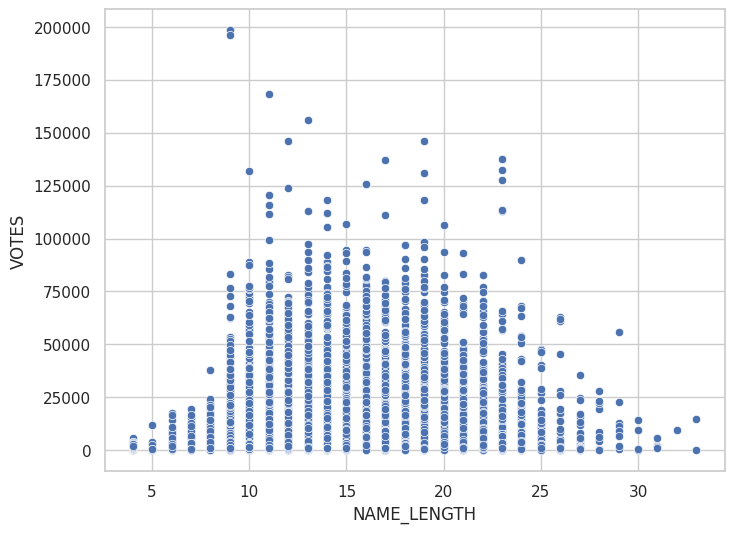

In [ ]:
state_df = pd.read_csv(f"{ST_NAME}.csv")
state_df['NAME_LENGTH'] = state_df['CANDIDATE'].apply(len)
plt.figure(figsize=(8, 6))
sns.scatterplot(x='NAME_LENGTH', y='VOTES', data=state_df)
plt.show()